# Vadere EMA connector demo
For more information on the use of the EMA Workbench, please refer to the [official EMA Workbench documentation](https://emaworkbench.readthedocs.io/en/latest/). This demo is based on the code provided on the documentation pages.

## Step 1: imports
The first step is to import the needed modules. This depends on the use and the type of analysis that is intended. The most important one here is the VadereModel from the model connectors. As said, please refer for more information on this to the [official EMA Workbench documentation](https://emaworkbench.readthedocs.io/en/latest/).

In [1]:
from ema_workbench import (perform_experiments, RealParameter, ema_logging,
                           MultiprocessingEvaluator,
                           ScalarOutcome, IntegerParameter, RealParameter)
from ema_workbench.em_framework.parameters import Category
from ema_workbench.connectors.vadere import VadereModel
import pandas as pd
import numpy as np

/home/tevito/anaconda3/envs/test/lib/python3.10/site-packages/ema_workbench-2.0.10-py3.10.egg/ema_workbench/em_framework/evaluators.py:21: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn(
/home/tevito/anaconda3/envs/test/lib/python3.10/site-packages/ema_workbench-2.0.10-py3.10.egg/ema_workbench/em_framework/optimization.py:48: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)
/home/tevito/anaconda3/envs/test/lib/python3.10/site-packages/ema_workbench-2.0.10-py3.10.egg/ema_workbench/connectors/__init__.py:17: ImportWarning: vensim connector not available
  warnings.warn("vensim connector not available", ImportWarning)
/home/tevito/anaconda3/envs/test/lib/python3.10/site-packages/ema_workbench-2.0.10-py3.10.egg/ema_workbench/connectors/__init__.py:27: ImportWarning: netlogo connector not available
  warnings.warn("netlogo connector not available", ImportWarning)


## Step 2: Setting up the model
In this example, we use the Vadere model from this research.  

In [2]:
# This model saves scalar results to a density.txt and speed.txt file.
model = VadereModel('model', 
                    vadere_jar='vadere-console.jar',
                    processor_files=[
                        'density.txt',
                        'speed.txt'
                    ],
                    model_file='baseCaseData.scenario',
                    wd='/home/tevito/Documents/EPA/Year2/thesis/git/CrowdSim/analysis/emaWorkingDirectory')

In [3]:
# set the number of replications to handle model stochasticity
model.replications = 2

Note that for specifying model uncertainties (and potential levers), the Vadere model class can change any variable present in the model file (Vadere scenario). To realize this, an exact location to the variable of interest in the Vadere scenario file has to be specified. Vadere scenario files follow a nested dictionary structure. Therefore, the exact location of the variable should be passed in a list of argumentes, passed as one string. See the example below, that variates the spawnNumber and maxSpawnNumber of source 0 and source 1 in the Vadere model.

In [4]:
model.uncertainties = [
    IntegerParameter(
        name='spawnFrequencyA',
        lower_bound=1,
        upper_bound=5,
        variable_name=[
            '("scenario", "topography", "sources", 0, "distributionParameters", "updateFrequency")',
        ]
    ),
    RealParameter(
        name='μFreeFlowSpeed',
        lower_bound=0.66,
        upper_bound=1.16,
        variable_name=[
            '("scenario", "topography", "attributesPedestrian", "speedDistributionMean")',
        ]
    ),
    RealParameter(
        name='pedPotentialHeight',
        lower_bound=5.0,
        upper_bound=50.0,
        variable_name=[
            '("scenario", "attributesModel", "org.vadere.state.attributes.models.AttributesPotentialCompactSoftshell", "pedPotentialHeight")',
        ]
    )
]

The model outcomes can be specified by passing the exact name as present in the output file (speed.txt here). The naming convention depends on the used Vadere data processors, but usually follows the name + id of the processor. When in doubt, it is advised to do a demo Vadere run using the Vadere software and to inspect the generated output files. Note that we take the mean of the outcomes here, since we specified multiple replications.

In [5]:
model.outcomes = [
    ScalarOutcome(
        name='meanSpeed',
        variable_name='mean_area_speed_processor-PID4',
        function=np.mean
    ),
    ScalarOutcome(
        name='meanDensityArea1',
        variable_name='mean_density_counting_normed_processor-PID6',
        function=np.mean
    ),
    ScalarOutcome(
        name='maxDensityArea1',
        variable_name='max_density_counting_normed_processor-PID7',
        function=np.mean
    ),
]

## Step 3: Performing experiments
The last step is to perform experiment with the Vadere model. Both sequential runs as runs in parallel are supported. Note however that a Vadere run can use a lot of RAM, and using all available CPU cores can lead to performance issues in some cases. Additionally, one Vadere run is by default already multithreaded. It is therefore recommended to not use the full set of available processes.

In [6]:
# enable EMA logging
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [7]:
# run in sequential 2 experiments
results_sequential = perform_experiments(
    model,
    scenarios=2,
    uncertainty_sampling='lhs'
)

[MainProcess/INFO] performing 2 scenarios * 1 policies * 1 model(s) = 2 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] 2 cases completed
[MainProcess/INFO] experiments finished


In [8]:
# run 6 experiments in parallel
with MultiprocessingEvaluator(model, n_processes=6) as evaluator:
        experiments, outcomes = evaluator.perform_experiments(
                scenarios=6,
                uncertainty_sampling='lhs'
)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 6 scenarios * 1 policies * 1 model(s) = 6 experiments
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] 2 cases completed
[MainProcess/INFO] 3 cases completed
[MainProcess/INFO] 4 cases completed
[MainProcess/INFO] 5 cases completed
[MainProcess/INFO] 6 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[ForkPoolWorker-4/INFO] finalizing
[ForkPoolWorker-3/INFO] finalizing
[ForkPoolWorker-5/INFO] finalizing
[ForkPoolWorker-2/INFO] finalizing
[ForkPoolWorker-1/INFO] finalizing
[ForkPoolWorker-6/INFO] finalizing


## Inspect the results
we can now look at the results and plot them. For more extensive exploratory analysis methods, or direct search, please refer to the [official EMA Workbench documentation](https://emaworkbench.readthedocs.io/en/latest/).

In [9]:
experiments.head()

,pedPotentialHeight,spawnFrequencyA,μFreeFlowSpeed,scenario,policy,model
0,41.794365,2.0,0.849640,2,None,model
1,33.274889,4.0,0.744074,3,None,model
2,48.154546,2.0,1.043306,4,None,model
3,8.646282,1.0,1.152779,5,None,model
4,25.356843,5.0,0.705747,6,None,model


In [10]:
pd.DataFrame(outcomes).head()

,meanSpeed,meanDensityArea1,maxDensityArea1
0,0.623462,0.505060,1.284891
1,0.582361,0.393817,0.753212
2,0.720919,0.394699,0.948161
3,0.853816,0.351734,0.832964
4,0.578332,0.376518,0.770935


/home/tevito/anaconda3/envs/test/lib/python3.10/site-packages/ema_workbench-2.0.10-py3.10.egg/ema_workbench/analysis/prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive "
[MainProcess/INFO] no time dimension found in results


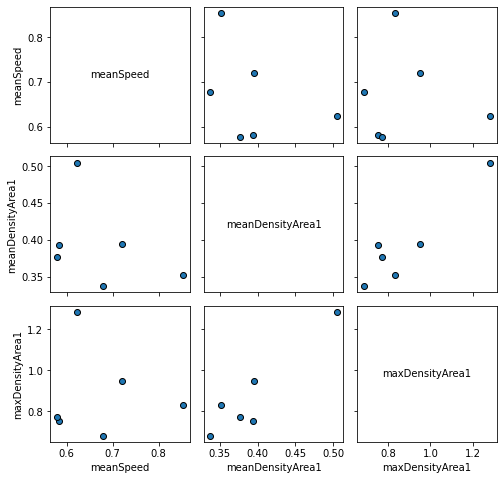

In [11]:
from ema_workbench.analysis import pairs_plotting
import matplotlib.pyplot as plt

fig, axes = pairs_plotting.pairs_scatter(experiments, outcomes,
                                        legend=False)
fig.set_size_inches(8,8)
plt.show()

# Using time series data
It is additionally possible to specify time series output data. See below for an example on how to do this. 

Note that this example now uses a different model class, since we do not want to average multiple scalar outcomes but are rather interested in a time series outcome. Hence, the SingleReplicationVadereModel is used. Now, the timeStep and average speeds are collected every step.

In [12]:
from ema_workbench import TimeSeriesOutcome
from ema_workbench.connectors.vadere import SingleReplicationVadereModel

In [13]:
model = SingleReplicationVadereModel('model', 
                    vadere_jar='vadere-console.jar',
                    processor_files=[
                        'speeds.csv'
                    ],
                    model_file='baseCaseDataTimeSeriesTest.scenario',
                    wd='/home/tevito/Documents/EPA/Year2/thesis/git/CrowdSim/analysis/emaWorkingDirectory')

In [14]:
model.uncertainties = [
    IntegerParameter(
        name='spawnFrequencyA',
        lower_bound=1,
        upper_bound=5,
        variable_name=[
            '("scenario", "topography", "sources", 0, "distributionParameters", "updateFrequency")',
        ]
    ),
    RealParameter(
        name='μFreeFlowSpeed',
        lower_bound=0.66,
        upper_bound=1.16,
        variable_name=[
            '("scenario", "topography", "attributesPedestrian", "speedDistributionMean")',
        ]
    ),
    RealParameter(
        name='pedPotentialHeight',
        lower_bound=5.0,
        upper_bound=50.0,
        variable_name=[
            '("scenario", "attributesModel", "org.vadere.state.attributes.models.AttributesPotentialCompactSoftshell", "pedPotentialHeight")',
        ]
    )
]

In [15]:
model.outcomes = [
    TimeSeriesOutcome(
        name='timeStep (in 0.4 second interval)',
        variable_name='timeStep',
    ),
    TimeSeriesOutcome(
        name='meanSpeed',
        variable_name='areaSpeed-PID1',
    )
]

In [16]:
# run 6 experiments in parallel
with MultiprocessingEvaluator(model, n_processes=6) as evaluator:
        experiments, outcomes = evaluator.perform_experiments(
                scenarios=6,
                uncertainty_sampling='lhs'
)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 6 scenarios * 1 policies * 1 model(s) = 6 experiments
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] 2 cases completed
[MainProcess/INFO] 3 cases completed
[MainProcess/INFO] 4 cases completed
[MainProcess/INFO] 5 cases completed
[MainProcess/INFO] 6 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[ForkPoolWorker-9/INFO] finalizing
[ForkPoolWorker-12/INFO] finalizing
[ForkPoolWorker-10/INFO] finalizing
[ForkPoolWorker-7/INFO] finalizing
[ForkPoolWorker-11/INFO] finalizing
[ForkPoolWorker-8/INFO] finalizing


(<Figure size 432x288 with 1 Axes>,
 {'meanSpeed': <AxesSubplot:title={'center':'meanSpeed'}, xlabel='Time', ylabel='meanSpeed'>})

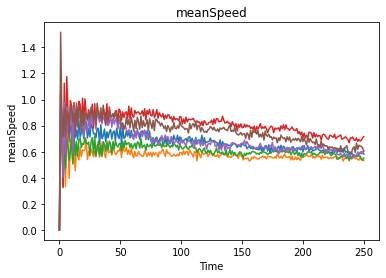

In [17]:
from ema_workbench.analysis.plotting import lines
lines(experiments, outcomes, outcomes_to_show='meanSpeed')